In [1]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# Define drift and diffusion functions
def mu(x, coupling_constants):
    return -0.5 * x + coupling_constants[0] * x

def sigma(x, coupling_constants):
    return 0.1 * (1 + coupling_constants[1])  # Ensure non-negative diffusion

class Time_Series_Generator:
    def __init__(self, num_nodes, coupling_constants, correlation_matrix):
        self.num_nodes = num_nodes
        self.coupling_constants = coupling_constants
        self.correlation_matrix = correlation_matrix
        self.correlation_decomposition = np.linalg.cholesky(correlation_matrix)  # Cholesky decomposition
        self.time_series = None

    def simulate_sde(self, mu, sigma, dt, num_steps):
        self.time_series = np.full((self.num_nodes, num_steps), 10.0)  # Initialize time series
        
        for t in range(1, num_steps):
            dW = np.random.normal(size=self.num_nodes) * np.sqrt(dt)
            correlated_noise = np.dot(self.correlation_decomposition, dW)
            
            drift = mu(self.time_series[:, t-1], self.coupling_constants) * dt
            diffusion = sigma(self.time_series[:, t-1], self.coupling_constants) * correlated_noise
            
            # Avoid overflow by capping drift and diffusion at smaller values
            drift = np.clip(drift, -5, 5)
            diffusion = np.clip(diffusion, -5, 5)
            
            # Additive update to avoid exponential growth and overflow
            self.time_series[:, t] = self.time_series[:, t-1] + drift + diffusion
            
            # Ensure the time series doesn't grow too large or become NaN
            self.time_series[:, t] = np.clip(self.time_series[:, t], -100, 100)

            # Check for any NaN values in time series (result from overflow)
            if np.any(np.isnan(self.time_series[:, t])):
                raise ValueError("NaN values encountered during simulation. Adjust the clipping or step size.")

    def get_correlation_matrix(self):
        if self.time_series is None:
            raise ValueError("Time series has not been simulated yet.")
        return np.corrcoef(self.time_series)

# Define parameter ranges for grid search
def create_grid(start, end, step):
    return np.arange(start, end + step, step)

def grid_search(num_nodes, target_correlation_matrix, dt, num_steps, parameter_ranges):
    best_error = float('inf')
    best_params = None
    
    # Create a grid of parameter combinations
    grids = [create_grid(start, end, step) for start, end, step in parameter_ranges]
    
    for coupling1 in grids[0]:
        for coupling2 in grids[1]:
            # Define coupling constants for the current grid point
            coupling_constants = np.array([coupling1, coupling2])
            
            # Create and simulate generator
            generator = Time_Series_Generator(num_nodes, coupling_constants, target_correlation_matrix)
            generator.simulate_sde(mu, sigma, dt, num_steps)
            simulated_correlation_matrix = generator.get_correlation_matrix()
            
            # Compute the error
            error = np.sum((simulated_correlation_matrix - target_correlation_matrix) ** 2)
            
            # Update the best parameters if the current error is lower
            if error < best_error:
                best_error = error
                best_params = coupling_constants
    
    return best_params, best_error

In [2]:
# Example usage
num_nodes = 5

# High correlation
target_correlation_matrix = np.array([
    [1.0, 0.9, 0.90, 0.8, 0.75],
    [0.9, 1.0, 0.88, 0.82, 0.78],
    [0.85, 0.88, 1.0, 0.86, 0.8],
    [0.8, 0.82, 0.86, 1.0, 0.85],
    [0.75, 0.78, 0.8, 0.85, 1.0]
])

dt = 0.01
num_steps = 1000

# Define parameter ranges for coupling constants
parameter_ranges = [(0.0, 1.0, 0.1), (0.0, 1.0, 0.1)]  # (start, end, step) for each constant

# Perform grid search
best_params, best_error = grid_search(num_nodes, target_correlation_matrix, dt, num_steps, parameter_ranges)

# Simulate with best parameters
t_series = Time_Series_Generator(num_nodes, best_params, target_correlation_matrix)
t_series.simulate_sde(mu, sigma, dt, num_steps)

In [3]:
print("Best coupling constants:", best_params)
print("Best error:", best_error)

Best coupling constants: [0.5 0.5]
Best error: 0.09615552388031524


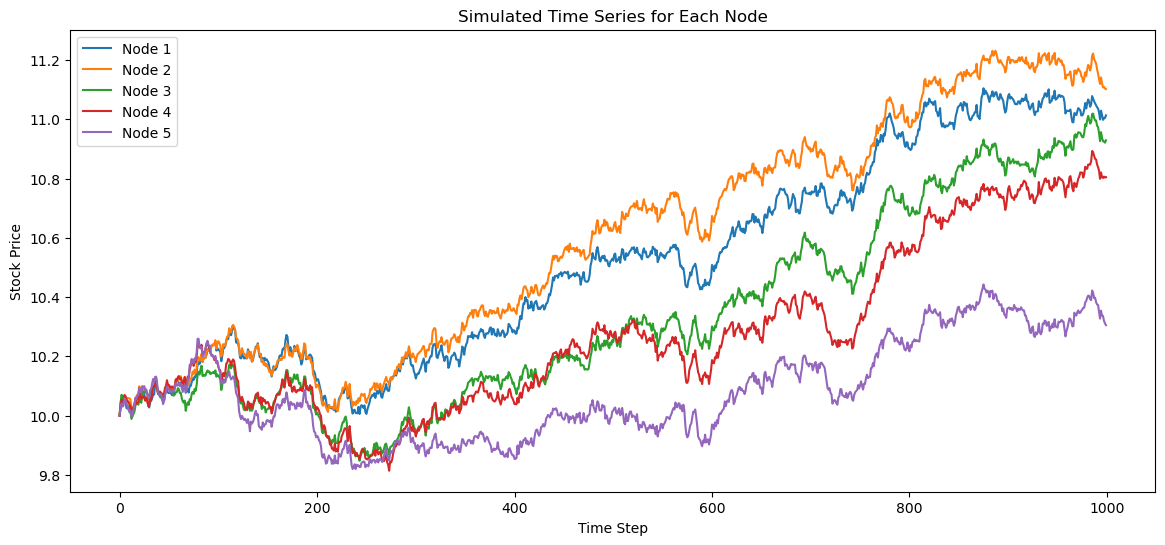

In [4]:
# Plotting the time series
plt.figure(figsize=(14, 6))
for i in range(num_nodes):
    plt.plot(t_series.time_series[i, :], label=f'Node {i+1}')
plt.title('Simulated Time Series for Each Node')
plt.xlabel('Time Step')
plt.ylabel('Stock Price')
plt.legend()
plt.show()

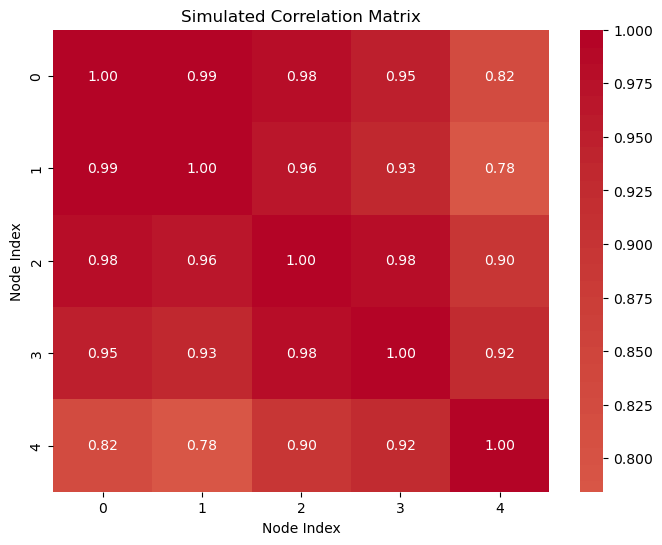

In [5]:
# Plotting the correlation matrix
simulated_correlation_matrix = t_series.get_correlation_matrix()
plt.figure(figsize=(8, 6))
sns.heatmap(simulated_correlation_matrix, annot=True, cmap='coolwarm', center=0, fmt='.2f')
plt.title('Simulated Correlation Matrix')
plt.xlabel('Node Index')
plt.ylabel('Node Index')
plt.show()

In [59]:
#Time series of a single node rescaled to match a stock-price
import pandas as pd

# Convert one of the nodes' time series to stock prices
node_index = 3  # Choose the node index to use
price_series = t_series.time_series[node_index]

# Normalize the stock prices to a realistic range
min_price, max_price = 50, 300
normalized_prices = np.interp(price_series, (price_series.min(), price_series.max()), (min_price, max_price))

# Create a date range 
dates = pd.date_range(start='2023-01-01', periods=num_steps, freq='D')
df = pd.DataFrame(data={'Date': dates, 'StockPrice': normalized_prices})
days=len(df['Date'])

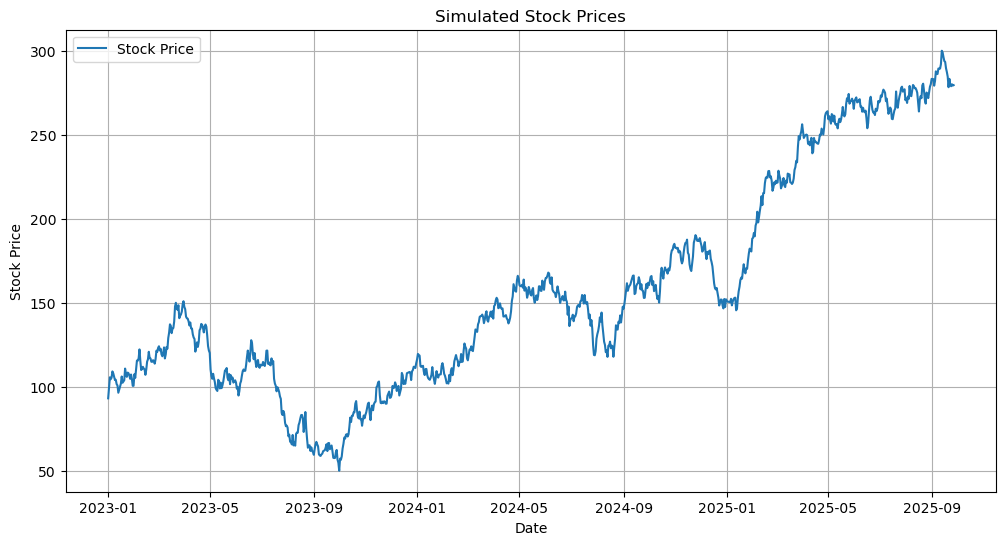

In [62]:
# Plot the stock prices
plt.figure(figsize=(12, 6))
plt.plot(df['Date'], df['StockPrice'], label='Stock Price')
plt.title('Simulated Stock Prices')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.legend()
plt.grid(True)
plt.show()

In [42]:
import numpy as np
from mesa import Agent, Model, DataCollector
from mesa.time import RandomActivation

In [64]:
class StockTradingAgent(Agent):
    """An agent that trades stocks."""
    
    def __init__(self, unique_id, model):
        super().__init__(unique_id, model)
        self.portfolio = 10000  # Starting cash
        self.holdings = 0        # Initial stock holdings
        self.buy_threshold = 30  # buy threshold
        self.sell_threshold = 60  # sell threshold
        self.moving_average_period = np.random.randint(5, 15)  # Varying moving average period

    def calculate_rsi(self, prices, period=5):
        """Calculate the Relative Strength Index (RSI) for the given price series."""
        if len(prices) < period:
            return None  # Not enough data to calculate RSI
        
        delta = np.diff(prices[-(period + 1):])  # Get price changes
        gain = np.where(delta > 0, delta, 0).mean()  # Average gain
        loss = -np.where(delta < 0, delta, 0).mean()  # Average loss

        # Avoid division by zero
        if loss == 0:
            return 100 if gain > 0 else 0

        rs = gain / loss  # Relative Strength
        rsi = 100 - (100 / (1 + rs))  # RSI calculation
        return rsi

    def calculate_moving_average(self, prices):
        """Calculate moving average."""
        if len(prices) < self.moving_average_period:
            return None
        return np.mean(prices[-self.moving_average_period:])

    def step(self):
        """Agent's trading behavior at each step."""
        current_step = self.model.schedule.steps
        
        # Ensure current_price is defined
        if current_step < len(self.model.stock_prices):
            current_price = self.model.stock_prices[current_step]
        else:
            current_price = self.model.stock_prices[-1]  # Last price if we run out of stock prices
            
        # Calculate indicators only if enough data is available
        rsi = self.calculate_rsi(self.model.stock_prices[:current_step + 1]) if current_step >= 5 else None
        moving_average = self.calculate_moving_average(self.model.stock_prices[:current_step + 1]) if current_step >= self.moving_average_period else None

        if rsi is None or moving_average is None:
            print(f"Agent {self.unique_id}: Not enough data for RSI or Moving Average.")
            return

        print(f"Agent {self.unique_id}: Current Price = ${current_price:.2f}, RSI = {rsi:.2f}, Moving Average = ${moving_average:.2f}")

        # Implement trading logic based on RSI and Moving Average
        if rsi < self.buy_threshold and self.portfolio >= current_price:  # Buy condition
            shares_to_buy = self.portfolio // current_price // 2  # Buy only half the possible shares
            cost = shares_to_buy * current_price
            if shares_to_buy > 0 and self.portfolio - cost >= 0:  # Ensure portfolio doesn't go negative
                self.holdings += shares_to_buy
                self.portfolio -= cost
                print(f"Agent {self.unique_id} buys {shares_to_buy} shares at ${current_price:.2f}. Portfolio: ${self.portfolio:.2f}, Holdings: {self.holdings} shares.")
        elif rsi > self.sell_threshold and self.holdings > 0:  # Sell condition
            shares_to_sell = self.holdings // 2  # Sell only half the holdings
            revenue = shares_to_sell * current_price
            if shares_to_sell > 0:
                self.holdings -= shares_to_sell
                self.portfolio += revenue
                print(f"Agent {self.unique_id} sells {shares_to_sell} shares at ${current_price:.2f}. Portfolio: ${self.portfolio:.2f}, Holdings: {self.holdings} shares.")

        # Additional logic: Buy if current price is below moving average and we have cash
        if current_price < moving_average and self.portfolio >= current_price:
            shares_to_buy = self.portfolio // current_price // 2  # Buy half of what can be bought
            cost = shares_to_buy * current_price
            if shares_to_buy > 0 and self.portfolio - cost >= 0:  # Ensure portfolio doesn't go negative
                self.holdings += shares_to_buy
                self.portfolio -= cost
                print(f"Agent {self.unique_id} buys {shares_to_buy} shares below moving average at ${current_price:.2f}. Portfolio: ${self.portfolio:.2f}, Holdings: {self.holdings} shares.")

class StockTradingModel(Model):
    """A model with some number of stock trading agents."""
    
    def __init__(self, num_agents, stock_prices):
        self.num_agents = num_agents
        self.stock_prices = stock_prices
        self.schedule = RandomActivation(self)
        self.datacollector = DataCollector(
            agent_reporters={"Portfolio": "portfolio"}
        )

        # Create agents
        for i in range(self.num_agents):
            agent = StockTradingAgent(i, self)
            self.schedule.add(agent)

    def step(self):
        """Advance the model by one step."""
        self.datacollector.collect(self)
        self.schedule.step()


In [69]:
model = StockTradingModel(num_agents=10, stock_prices=df['StockPrice'])

trading_period=700 #in days


# Run the model for a specified number of steps
for _ in range(trading_period):
    model.step()

Agent 7: Not enough data for RSI or Moving Average.
Agent 4: Not enough data for RSI or Moving Average.
Agent 6: Not enough data for RSI or Moving Average.
Agent 9: Not enough data for RSI or Moving Average.
Agent 1: Not enough data for RSI or Moving Average.
Agent 0: Not enough data for RSI or Moving Average.
Agent 3: Not enough data for RSI or Moving Average.
Agent 2: Not enough data for RSI or Moving Average.
Agent 8: Not enough data for RSI or Moving Average.
Agent 5: Not enough data for RSI or Moving Average.
Agent 8: Not enough data for RSI or Moving Average.
Agent 5: Not enough data for RSI or Moving Average.
Agent 9: Not enough data for RSI or Moving Average.
Agent 0: Not enough data for RSI or Moving Average.
Agent 7: Not enough data for RSI or Moving Average.
Agent 2: Not enough data for RSI or Moving Average.
Agent 3: Not enough data for RSI or Moving Average.
Agent 4: Not enough data for RSI or Moving Average.
Agent 6: Not enough data for RSI or Moving Average.
Agent 1: Not

Agent 1: Current Price = $121.44, RSI = 80.79, Moving Average = $116.69
Agent 1 sells 24.0 shares at $121.44. Portfolio: $9282.03, Holdings: 24.0 shares.
Agent 7: Current Price = $121.44, RSI = 80.79, Moving Average = $116.54
Agent 7 sells 25.0 shares at $121.44. Portfolio: $9625.42, Holdings: 25.0 shares.
Agent 8: Current Price = $121.44, RSI = 80.79, Moving Average = $116.73
Agent 8 sells 24.0 shares at $121.44. Portfolio: $9000.86, Holdings: 25.0 shares.
Agent 9: Current Price = $121.44, RSI = 80.79, Moving Average = $116.54
Agent 9 sells 25.0 shares at $121.44. Portfolio: $9625.42, Holdings: 25.0 shares.
Agent 6: Current Price = $121.44, RSI = 80.79, Moving Average = $116.17
Agent 6 sells 24.0 shares at $121.44. Portfolio: $8664.66, Holdings: 25.0 shares.
Agent 5: Current Price = $121.44, RSI = 80.79, Moving Average = $115.41
Agent 5 sells 23.0 shares at $121.44. Portfolio: $9159.10, Holdings: 24.0 shares.
Agent 4: Current Price = $121.44, RSI = 80.79, Moving Average = $116.07
Agen

Agent 0: Current Price = $140.75, RSI = 15.54, Moving Average = $145.03
Agent 0 buys 21.0 shares at $140.75. Portfolio: $3216.71, Holdings: 74.0 shares.
Agent 0 buys 11.0 shares below moving average at $140.75. Portfolio: $1668.43, Holdings: 85.0 shares.
Agent 9: Current Price = $140.75, RSI = 15.54, Moving Average = $145.09
Agent 9 buys 11.0 shares at $140.75. Portfolio: $1733.24, Holdings: 87.0 shares.
Agent 9 buys 6.0 shares below moving average at $140.75. Portfolio: $888.73, Holdings: 93.0 shares.
Agent 7: Current Price = $140.75, RSI = 15.54, Moving Average = $145.09
Agent 7 buys 11.0 shares at $140.75. Portfolio: $1733.24, Holdings: 87.0 shares.
Agent 7 buys 6.0 shares below moving average at $140.75. Portfolio: $888.73, Holdings: 93.0 shares.
Agent 5: Current Price = $140.75, RSI = 15.54, Moving Average = $145.54
Agent 5 buys 21.0 shares at $140.75. Portfolio: $3151.05, Holdings: 73.0 shares.
Agent 5 buys 11.0 shares below moving average at $140.75. Portfolio: $1602.78, Holding

Agent 4: Current Price = $97.47, RSI = 0.00, Moving Average = $102.15
Agent 1: Current Price = $97.47, RSI = 0.00, Moving Average = $106.66
Agent 8: Current Price = $97.47, RSI = 0.00, Moving Average = $105.18
Agent 6: Current Price = $97.47, RSI = 0.00, Moving Average = $102.67
Agent 2: Current Price = $97.47, RSI = 0.00, Moving Average = $103.52
Agent 0: Current Price = $97.47, RSI = 0.00, Moving Average = $106.66
Agent 7: Current Price = $97.47, RSI = 0.00, Moving Average = $108.13
Agent 3: Current Price = $97.47, RSI = 0.00, Moving Average = $100.53
Agent 2: Current Price = $104.14, RSI = 46.86, Moving Average = $102.84
Agent 9: Current Price = $104.14, RSI = 46.86, Moving Average = $106.45
Agent 7: Current Price = $104.14, RSI = 46.86, Moving Average = $106.45
Agent 0: Current Price = $104.14, RSI = 46.86, Moving Average = $105.08
Agent 5: Current Price = $104.14, RSI = 46.86, Moving Average = $109.45
Agent 8: Current Price = $104.14, RSI = 46.86, Moving Average = $103.58
Agent 3:

Agent 1: Current Price = $120.56, RSI = 68.35, Moving Average = $113.70
Agent 3: Current Price = $120.56, RSI = 68.35, Moving Average = $118.52
Agent 3 sells 22.0 shares at $120.56. Portfolio: $7854.18, Holdings: 23.0 shares.
Agent 2: Current Price = $120.56, RSI = 68.35, Moving Average = $114.98
Agent 0: Current Price = $120.56, RSI = 68.35, Moving Average = $113.70
Agent 9: Current Price = $120.56, RSI = 68.35, Moving Average = $112.84
Agent 7: Current Price = $120.56, RSI = 68.35, Moving Average = $112.84
Agent 8: Current Price = $120.56, RSI = 68.35, Moving Average = $114.41
Agent 2: Current Price = $127.68, RSI = 71.64, Moving Average = $116.91
Agent 9: Current Price = $127.68, RSI = 71.64, Moving Average = $114.87
Agent 3: Current Price = $127.68, RSI = 71.64, Moving Average = $120.51
Agent 3 sells 11.0 shares at $127.68. Portfolio: $9258.66, Holdings: 12.0 shares.
Agent 6: Current Price = $127.68, RSI = 71.64, Moving Average = $117.84
Agent 7: Current Price = $127.68, RSI = 71.6

Agent 5: Current Price = $96.90, RSI = 24.91, Moving Average = $107.11
Agent 4: Current Price = $96.90, RSI = 24.91, Moving Average = $99.96
Agent 8: Current Price = $96.90, RSI = 24.91, Moving Average = $104.57
Agent 3: Current Price = $96.90, RSI = 24.91, Moving Average = $98.61
Agent 1: Current Price = $96.90, RSI = 24.91, Moving Average = $105.32
Agent 3: Current Price = $94.20, RSI = 21.81, Moving Average = $97.34
Agent 7: Current Price = $94.20, RSI = 21.81, Moving Average = $104.39
Agent 9: Current Price = $94.20, RSI = 21.81, Moving Average = $104.39
Agent 0: Current Price = $94.20, RSI = 21.81, Moving Average = $103.63
Agent 1: Current Price = $94.20, RSI = 21.81, Moving Average = $103.63
Agent 8: Current Price = $94.20, RSI = 21.81, Moving Average = $102.31
Agent 5: Current Price = $94.20, RSI = 21.81, Moving Average = $105.73
Agent 4: Current Price = $94.20, RSI = 21.81, Moving Average = $98.45
Agent 2: Current Price = $94.20, RSI = 21.81, Moving Average = $101.02
Agent 6: C

Agent 0: Current Price = $63.94, RSI = 29.55, Moving Average = $70.92
Agent 9: Current Price = $63.94, RSI = 29.55, Moving Average = $71.94
Agent 3: Current Price = $63.94, RSI = 29.55, Moving Average = $63.87
Agent 7: Current Price = $63.94, RSI = 29.55, Moving Average = $71.94
Agent 4: Current Price = $63.94, RSI = 29.55, Moving Average = $66.23
Agent 1: Current Price = $63.94, RSI = 29.55, Moving Average = $70.92
Agent 5: Current Price = $63.94, RSI = 29.55, Moving Average = $73.39
Agent 8: Current Price = $63.94, RSI = 29.55, Moving Average = $69.87
Agent 2: Current Price = $63.94, RSI = 29.55, Moving Average = $69.51
Agent 4: Current Price = $61.85, RSI = 39.91, Moving Average = $64.30
Agent 5: Current Price = $61.85, RSI = 39.91, Moving Average = $72.02
Agent 6: Current Price = $61.85, RSI = 39.91, Moving Average = $65.68
Agent 2: Current Price = $61.85, RSI = 39.91, Moving Average = $67.82
Agent 8: Current Price = $61.85, RSI = 39.91, Moving Average = $68.74
Agent 7: Current Pri

Agent 1: Current Price = $56.48, RSI = 35.46, Moving Average = $57.53
Agent 5: Current Price = $56.48, RSI = 35.46, Moving Average = $58.89
Agent 4: Current Price = $56.48, RSI = 35.46, Moving Average = $56.89
Agent 6: Current Price = $56.48, RSI = 35.46, Moving Average = $56.98
Agent 9: Current Price = $56.48, RSI = 35.46, Moving Average = $58.15
Agent 8: Current Price = $56.48, RSI = 35.46, Moving Average = $57.11
Agent 0: Current Price = $56.48, RSI = 35.46, Moving Average = $57.53
Agent 3: Current Price = $56.48, RSI = 35.46, Moving Average = $55.00
Agent 7: Current Price = $56.48, RSI = 35.46, Moving Average = $58.15
Agent 6: Current Price = $58.54, RSI = 55.87, Moving Average = $57.09
Agent 2: Current Price = $58.54, RSI = 55.87, Moving Average = $57.15
Agent 3: Current Price = $58.54, RSI = 55.87, Moving Average = $55.39
Agent 0: Current Price = $58.54, RSI = 55.87, Moving Average = $57.24
Agent 1: Current Price = $58.54, RSI = 55.87, Moving Average = $57.24
Agent 9: Current Pri

Agent 4: Current Price = $90.50, RSI = 100.00, Moving Average = $85.75
Agent 4 sells 5.0 shares at $90.50. Portfolio: $6732.96, Holdings: 6.0 shares.
Agent 8: Current Price = $90.50, RSI = 100.00, Moving Average = $83.82
Agent 8 sells 6.0 shares at $90.50. Portfolio: $7436.38, Holdings: 6.0 shares.
Agent 9: Current Price = $90.50, RSI = 100.00, Moving Average = $83.66
Agent 9 sells 6.0 shares at $90.50. Portfolio: $8109.42, Holdings: 7.0 shares.
Agent 7: Current Price = $90.50, RSI = 100.00, Moving Average = $83.66
Agent 7 sells 6.0 shares at $90.50. Portfolio: $8109.42, Holdings: 7.0 shares.
Agent 6: Current Price = $90.50, RSI = 100.00, Moving Average = $85.08
Agent 6 sells 5.0 shares at $90.50. Portfolio: $7025.13, Holdings: 6.0 shares.
Agent 1: Current Price = $90.50, RSI = 100.00, Moving Average = $83.53
Agent 1 sells 6.0 shares at $90.50. Portfolio: $7742.69, Holdings: 6.0 shares.
Agent 3: Current Price = $90.50, RSI = 100.00, Moving Average = $87.23
Agent 3 sells 5.0 shares at $

Agent 9: Current Price = $94.79, RSI = 21.73, Moving Average = $98.12
Agent 9 buys 26.0 shares at $94.79. Portfolio: $2475.05, Holdings: 76.0 shares.
Agent 9 buys 13.0 shares below moving average at $94.79. Portfolio: $1242.80, Holdings: 89.0 shares.
Agent 2: Current Price = $94.79, RSI = 21.73, Moving Average = $99.46
Agent 2 buys 23.0 shares at $94.79. Portfolio: $2247.76, Holdings: 68.0 shares.
Agent 2 buys 11.0 shares below moving average at $94.79. Portfolio: $1205.09, Holdings: 79.0 shares.
Agent 6: Current Price = $94.79, RSI = 21.73, Moving Average = $99.34
Agent 6 buys 11.0 shares at $94.79. Portfolio: $1086.27, Holdings: 75.0 shares.
Agent 6 buys 5.0 shares below moving average at $94.79. Portfolio: $612.33, Holdings: 80.0 shares.
Agent 7: Current Price = $94.79, RSI = 21.73, Moving Average = $98.12
Agent 7 buys 26.0 shares at $94.79. Portfolio: $2475.05, Holdings: 76.0 shares.
Agent 7 buys 13.0 shares below moving average at $94.79. Portfolio: $1242.80, Holdings: 89.0 shares

Agent 0: Current Price = $111.68, RSI = 87.30, Moving Average = $107.44
Agent 0 sells 48.0 shares at $111.68. Portfolio: $5468.96, Holdings: 48.0 shares.
Agent 2: Current Price = $106.91, RSI = 59.19, Moving Average = $106.93
Agent 2 buys 24.0 shares below moving average at $106.91. Portfolio: $2568.31, Holdings: 70.0 shares.
Agent 9: Current Price = $106.91, RSI = 59.19, Moving Average = $107.39
Agent 9 buys 26.0 shares below moving average at $106.91. Portfolio: $2921.87, Holdings: 77.0 shares.
Agent 4: Current Price = $106.91, RSI = 59.19, Moving Average = $106.42
Agent 5: Current Price = $106.91, RSI = 59.19, Moving Average = $108.09
Agent 5 buys 26.0 shares below moving average at $106.91. Portfolio: $2909.07, Holdings: 76.0 shares.
Agent 8: Current Price = $106.91, RSI = 59.19, Moving Average = $107.29
Agent 8 buys 24.0 shares below moving average at $106.91. Portfolio: $2764.84, Holdings: 71.0 shares.
Agent 3: Current Price = $106.91, RSI = 59.19, Moving Average = $107.03
Agent 

Agent 3: Current Price = $122.69, RSI = 78.27, Moving Average = $121.72
Agent 3 sells 4.0 shares at $122.69. Portfolio: $10820.70, Holdings: 4.0 shares.
Agent 4: Current Price = $122.69, RSI = 78.27, Moving Average = $120.40
Agent 4 sells 4.0 shares at $122.69. Portfolio: $10336.03, Holdings: 4.0 shares.
Agent 2: Current Price = $122.69, RSI = 78.27, Moving Average = $119.12
Agent 2 sells 4.0 shares at $122.69. Portfolio: $10972.74, Holdings: 4.0 shares.
Agent 1: Current Price = $122.69, RSI = 78.27, Moving Average = $118.17
Agent 1 sells 4.0 shares at $122.69. Portfolio: $11457.72, Holdings: 5.0 shares.
Agent 9: Current Price = $122.69, RSI = 78.27, Moving Average = $118.04
Agent 9 sells 4.0 shares at $122.69. Portfolio: $11910.56, Holdings: 4.0 shares.
Agent 6: Current Price = $122.69, RSI = 78.27, Moving Average = $119.69
Agent 6 sells 4.0 shares at $122.69. Portfolio: $10449.44, Holdings: 4.0 shares.
Agent 5: Current Price = $122.69, RSI = 78.27, Moving Average = $118.02
Agent 5 se

Agent 4: Current Price = $146.75, RSI = 44.50, Moving Average = $148.61
Agent 4 buys 40.0 shares below moving average at $146.75. Portfolio: $6091.30, Holdings: 42.0 shares.
Agent 0: Current Price = $146.75, RSI = 44.50, Moving Average = $146.72
Agent 9: Current Price = $146.75, RSI = 44.50, Moving Average = $146.29
Agent 9: Current Price = $147.15, RSI = 42.89, Moving Average = $146.76
Agent 1: Current Price = $147.15, RSI = 42.89, Moving Average = $147.14
Agent 2: Current Price = $147.15, RSI = 42.89, Moving Average = $148.04
Agent 2 buys 21.0 shares below moving average at $147.15. Portfolio: $3279.32, Holdings: 66.0 shares.
Agent 8: Current Price = $147.15, RSI = 42.89, Moving Average = $147.39
Agent 8 buys 22.0 shares below moving average at $147.15. Portfolio: $3342.26, Holdings: 68.0 shares.
Agent 7: Current Price = $147.15, RSI = 42.89, Moving Average = $146.76
Agent 6: Current Price = $147.15, RSI = 42.89, Moving Average = $148.43
Agent 6 buys 20.0 shares below moving average 

Agent 4: Current Price = $157.39, RSI = 43.98, Moving Average = $157.00
Agent 9: Current Price = $157.39, RSI = 43.98, Moving Average = $158.52
Agent 8: Current Price = $157.39, RSI = 43.98, Moving Average = $158.24
Agent 1: Current Price = $157.39, RSI = 43.98, Moving Average = $158.40
Agent 7: Current Price = $157.39, RSI = 43.98, Moving Average = $158.52
Agent 8: Current Price = $154.92, RSI = 40.57, Moving Average = $157.66
Agent 5: Current Price = $154.92, RSI = 40.57, Moving Average = $158.40
Agent 2: Current Price = $154.92, RSI = 40.57, Moving Average = $157.52
Agent 9: Current Price = $154.92, RSI = 40.57, Moving Average = $158.11
Agent 7: Current Price = $154.92, RSI = 40.57, Moving Average = $158.11
Agent 6: Current Price = $154.92, RSI = 40.57, Moving Average = $156.74
Agent 4: Current Price = $154.92, RSI = 40.57, Moving Average = $156.68
Agent 3: Current Price = $154.92, RSI = 40.57, Moving Average = $155.93
Agent 1: Current Price = $154.92, RSI = 40.57, Moving Average = 

Agent 0: Current Price = $157.74, RSI = 21.63, Moving Average = $163.40
Agent 0 buys 11.0 shares at $157.74. Portfolio: $1886.51, Holdings: 78.0 shares.
Agent 0 buys 5.0 shares below moving average at $157.74. Portfolio: $1097.79, Holdings: 83.0 shares.
Agent 3: Current Price = $157.74, RSI = 21.63, Moving Average = $162.70
Agent 3 buys 11.0 shares at $157.74. Portfolio: $1846.87, Holdings: 77.0 shares.
Agent 3 buys 5.0 shares below moving average at $157.74. Portfolio: $1058.15, Holdings: 82.0 shares.
Agent 7: Current Price = $157.74, RSI = 21.63, Moving Average = $163.03
Agent 7 buys 12.0 shares at $157.74. Portfolio: $1905.47, Holdings: 80.0 shares.
Agent 7 buys 6.0 shares below moving average at $157.74. Portfolio: $959.01, Holdings: 86.0 shares.
Agent 7: Current Price = $156.69, RSI = 21.03, Moving Average = $162.84
Agent 7 buys 3.0 shares at $156.69. Portfolio: $488.93, Holdings: 89.0 shares.
Agent 7 buys 1.0 shares below moving average at $156.69. Portfolio: $332.24, Holdings: 9

Agent 1: Current Price = $147.51, RSI = 85.58, Moving Average = $143.90
Agent 1 sells 2.0 shares at $147.51. Portfolio: $13060.71, Holdings: 3.0 shares.
Agent 9: Current Price = $147.51, RSI = 85.58, Moving Average = $143.55
Agent 9 sells 2.0 shares at $147.51. Portfolio: $13265.59, Holdings: 3.0 shares.
Agent 8: Current Price = $147.51, RSI = 85.58, Moving Average = $144.23
Agent 8 sells 2.0 shares at $147.51. Portfolio: $12526.45, Holdings: 2.0 shares.
Agent 3: Current Price = $147.51, RSI = 85.58, Moving Average = $147.14
Agent 3 sells 1.0 shares at $147.51. Portfolio: $12942.78, Holdings: 2.0 shares.
Agent 5: Current Price = $147.51, RSI = 85.58, Moving Average = $143.31
Agent 5 sells 4.0 shares at $147.51. Portfolio: $12997.11, Holdings: 5.0 shares.
Agent 0: Current Price = $147.51, RSI = 85.58, Moving Average = $143.90
Agent 0 sells 2.0 shares at $147.51. Portfolio: $13060.71, Holdings: 3.0 shares.
Agent 9: Current Price = $150.81, RSI = 87.93, Moving Average = $144.48
Agent 9 se

Agent 1: Current Price = $144.15, RSI = 86.16, Moving Average = $130.65
Agent 1 sells 1.0 shares at $144.15. Portfolio: $11875.49, Holdings: 2.0 shares.
Agent 8: Current Price = $144.15, RSI = 86.16, Moving Average = $131.24
Agent 8 sells 1.0 shares at $144.15. Portfolio: $11245.36, Holdings: 2.0 shares.
Agent 9: Current Price = $144.15, RSI = 86.16, Moving Average = $130.98
Agent 9 sells 2.0 shares at $144.15. Portfolio: $12011.64, Holdings: 3.0 shares.
Agent 2: Current Price = $144.15, RSI = 86.16, Moving Average = $132.61
Agent 2 sells 1.0 shares at $144.15. Portfolio: $11142.98, Holdings: 2.0 shares.
Agent 5: Current Price = $144.15, RSI = 86.16, Moving Average = $131.98
Agent 5 sells 4.0 shares at $144.15. Portfolio: $12398.33, Holdings: 5.0 shares.
Agent 5: Current Price = $136.69, RSI = 57.46, Moving Average = $132.00
Agent 2: Current Price = $136.69, RSI = 57.46, Moving Average = $134.61
Agent 0: Current Price = $136.69, RSI = 57.46, Moving Average = $131.74
Agent 7: Current Pr

Agent 6: Current Price = $142.44, RSI = 73.21, Moving Average = $134.47
Agent 6 sells 1.0 shares at $142.44. Portfolio: $11491.82, Holdings: 1.0 shares.
Agent 4: Current Price = $142.44, RSI = 73.21, Moving Average = $136.04
Agent 4 sells 1.0 shares at $142.44. Portfolio: $10959.26, Holdings: 1.0 shares.
Agent 5: Current Price = $142.44, RSI = 73.21, Moving Average = $129.74
Agent 5 sells 1.0 shares at $142.44. Portfolio: $13681.57, Holdings: 1.0 shares.
Agent 7: Current Price = $142.44, RSI = 73.21, Moving Average = $130.42
Agent 7 sells 1.0 shares at $142.44. Portfolio: $12720.94, Holdings: 1.0 shares.
Agent 9: Current Price = $142.44, RSI = 73.21, Moving Average = $130.42
Agent 9 sells 1.0 shares at $142.44. Portfolio: $12720.94, Holdings: 1.0 shares.
Agent 8: Current Price = $138.26, RSI = 63.89, Moving Average = $133.19
Agent 2: Current Price = $138.26, RSI = 63.89, Moving Average = $134.90
Agent 6: Current Price = $138.26, RSI = 63.89, Moving Average = $136.32
Agent 7: Current Pr

Agent 6: Current Price = $163.16, RSI = 82.47, Moving Average = $161.02
Agent 6 sells 18.0 shares at $163.16. Portfolio: $9304.16, Holdings: 18.0 shares.
Agent 2: Current Price = $163.16, RSI = 82.47, Moving Average = $161.58
Agent 2 sells 18.0 shares at $163.16. Portfolio: $9581.28, Holdings: 19.0 shares.
Agent 3: Current Price = $163.16, RSI = 82.47, Moving Average = $162.22
Agent 3 sells 18.0 shares at $163.16. Portfolio: $9688.67, Holdings: 19.0 shares.
Agent 4: Current Price = $163.16, RSI = 82.47, Moving Average = $160.27
Agent 4 sells 17.0 shares at $163.16. Portfolio: $8909.24, Holdings: 17.0 shares.
Agent 0: Current Price = $163.16, RSI = 82.47, Moving Average = $161.94
Agent 0 sells 19.0 shares at $163.16. Portfolio: $10296.28, Holdings: 19.0 shares.
Agent 5: Current Price = $163.16, RSI = 82.47, Moving Average = $161.51
Agent 5 sells 19.0 shares at $163.16. Portfolio: $11259.74, Holdings: 20.0 shares.
Agent 8: Current Price = $157.98, RSI = 42.04, Moving Average = $161.22
Ag

Agent 7: Current Price = $167.31, RSI = 64.07, Moving Average = $164.63
Agent 3: Current Price = $170.37, RSI = 58.24, Moving Average = $169.44
Agent 7: Current Price = $170.37, RSI = 58.24, Moving Average = $165.99
Agent 5: Current Price = $170.37, RSI = 58.24, Moving Average = $164.15
Agent 1: Current Price = $170.37, RSI = 58.24, Moving Average = $167.43
Agent 8: Current Price = $170.37, RSI = 58.24, Moving Average = $168.50
Agent 6: Current Price = $170.37, RSI = 58.24, Moving Average = $168.39
Agent 2: Current Price = $170.37, RSI = 58.24, Moving Average = $168.65
Agent 4: Current Price = $170.37, RSI = 58.24, Moving Average = $168.64
Agent 0: Current Price = $170.37, RSI = 58.24, Moving Average = $167.43
Agent 9: Current Price = $170.37, RSI = 58.24, Moving Average = $165.99
Agent 5: Current Price = $169.15, RSI = 38.43, Moving Average = $165.36
Agent 7: Current Price = $169.15, RSI = 38.43, Moving Average = $167.58
Agent 2: Current Price = $169.15, RSI = 38.43, Moving Average = 

Agent 1 sells 10.0 shares at $190.23. Portfolio: $13571.12, Holdings: 11.0 shares.
Agent 2: Current Price = $190.23, RSI = 100.00, Moving Average = $178.32
Agent 2 sells 10.0 shares at $190.23. Portfolio: $13209.41, Holdings: 10.0 shares.
Agent 9: Current Price = $190.23, RSI = 100.00, Moving Average = $179.82
Agent 9 sells 10.0 shares at $190.23. Portfolio: $13788.56, Holdings: 11.0 shares.
Agent 8: Current Price = $190.23, RSI = 100.00, Moving Average = $178.47
Agent 8 sells 10.0 shares at $190.23. Portfolio: $12989.90, Holdings: 10.0 shares.
Agent 6: Current Price = $190.23, RSI = 100.00, Moving Average = $178.28
Agent 6 sells 9.0 shares at $190.23. Portfolio: $12546.31, Holdings: 10.0 shares.
Agent 0: Current Price = $189.05, RSI = 93.40, Moving Average = $179.43
Agent 0 sells 5.0 shares at $189.05. Portfolio: $14516.37, Holdings: 6.0 shares.
Agent 9: Current Price = $189.05, RSI = 93.40, Moving Average = $180.10
Agent 9 sells 5.0 shares at $189.05. Portfolio: $14733.81, Holdings: 

In [70]:
# Print final holdings, portfolio values, and net worth for each agent
print("\nFinal Holdings, Portfolio Values, and Net Worth:")
current_price = np.array(model.stock_prices)[trading_period-1]  # Get the last stock price

for agent in model.schedule.agents:
    net_worth = agent.portfolio + (agent.holdings * current_price)  # Calculate net worth
    print(f"Agent {agent.unique_id}: Portfolio = ${agent.portfolio:.2f}, Holdings = {agent.holdings} shares, Net Worth = ${net_worth:.2f}")


Final Holdings, Portfolio Values, and Net Worth:
Agent 9: Portfolio = $15294.37, Holdings = 3.0 shares, Net Worth = $15859.77
Agent 0: Portfolio = $15076.93, Holdings = 3.0 shares, Net Worth = $15642.33
Agent 7: Portfolio = $15294.37, Holdings = 3.0 shares, Net Worth = $15859.77
Agent 3: Portfolio = $1954.08, Holdings = 70.0 shares, Net Worth = $15146.78
Agent 1: Portfolio = $15076.93, Holdings = 3.0 shares, Net Worth = $15642.33
Agent 8: Portfolio = $14308.86, Holdings = 3.0 shares, Net Worth = $14874.26
Agent 6: Portfolio = $13865.26, Holdings = 3.0 shares, Net Worth = $14430.67
Agent 2: Portfolio = $14528.37, Holdings = 3.0 shares, Net Worth = $15093.77
Agent 5: Portfolio = $16584.00, Holdings = 3.0 shares, Net Worth = $17149.41
Agent 4: Portfolio = $6739.55, Holdings = 38.0 shares, Net Worth = $13901.30
